In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
import matplotlib.pyplot as plt
import xskillscore as xs

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

import torch_funcs
import torch_s2s_dataset_gust

Matplotlib is building the font cache; this may take a moment.


In [2]:
def reverse_negone(ds, minv, maxv):
    """
    reversing negative zero-to-one normalization
    """
    return (((ds + 1) / 2) * (maxv - minv)) + minv

In [3]:
var = 'tas2m'
wks = 2

train = torch_s2s_dataset_gust.S2SDataset(
    
    week=wks, variable=var, norm='minmax', region='fixed',
    
    minv=None, maxv=None, mnv=None, stdv=None,
    
    lon0=250., lat0=30., dxdy=32., feat_topo=True, feat_lats=True, feat_lons=True,
    
    startdt='1999-02-01', enddt='2015-12-31', homedir='/glade/gust/scratch/molina/'
)

In [4]:
valid = torch_s2s_dataset_gust.S2SDataset(
    
    week=wks, variable=var, norm='minmax', region='fixed',
    
    minv=train.min_val, maxv=train.max_val, mnv=None, stdv=None,
    
    lon0=250., lat0=30., dxdy=32., feat_topo=True, feat_lats=True, feat_lons=True,
    
    startdt='2016-01-01', enddt='2017-12-31', homedir='/glade/gust/scratch/molina/'
)

tests = torch_s2s_dataset_gust.S2SDataset(
    
    week=wks, variable=var, norm='minmax', region='fixed',
    
    minv=train.min_val, maxv=train.max_val, mnv=None, stdv=None,
    
    lon0=250., lat0=30., dxdy=32., feat_topo=True, feat_lats=True, feat_lons=True,
    
    startdt='2018-01-01', enddt='2020-12-31', homedir='/glade/gust/scratch/molina/'
)

In [5]:
BATCH_SIZE=64

In [6]:
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
tests_loader = DataLoader(tests, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

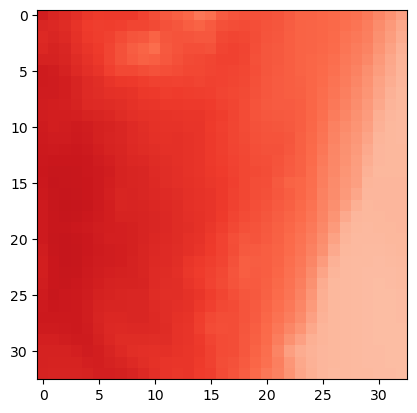

AxesImage(size=(33, 33)) None


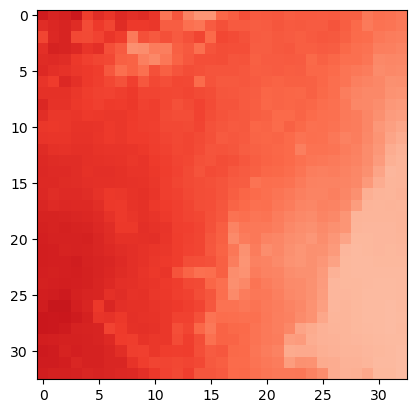

AxesImage(size=(33, 33)) None


In [7]:
for i in valid_loader:
    print(plt.imshow(i['input'].squeeze(dim=2)[20,3:4,:,:][0], vmin=0.5, vmax=1, cmap='Reds'), plt.show())
    print(plt.imshow(i['label'].squeeze(dim=2)[20,0,:,:], vmin=0.5, vmax=1, cmap='Reds'), plt.show())
    break

In [8]:
def train_func(model, dataloader, nc):
    """
    Training function.
    
    Args:
        model (torch): pytorch neural network.
        dataloader (torch): pytorch dataloader.
        nc (int): number of channels.
    """
    model.train()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    corrcoef_true = 0.0
    
    for data in dataloader:
        
        img_noisy = data['input'].squeeze(dim=2)
        img_noisy = img_noisy.to(device, dtype=torch.float)
        
        img_label = data['label'].squeeze(dim=2)
        img_label = img_label.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(img_noisy)
        
        loss = criterion(outputs, img_label)
        closs = torch_funcs.corrcoef(outputs, img_label) # corr b/w unet and era5
        tloss = torch_funcs.corrcoef(img_noisy[:,nc-1:nc,:,:], img_label) # corr b/w cesm2 and era5
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        corrcoef_loss += closs.item()
        corrcoef_true += tloss.item()
    
    train_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    coef_true = corrcoef_true / len(dataloader)
    
    return train_loss, coef_loss, coef_true

In [9]:
def valid_func(model, dataloader, nc):
    """
    Validation function.
    
    Args:
        model: pytorch neural network.
        dataloader: pytorch dataloader.
        nc (int): number of channels.
    """
    model.eval()
    
    running_loss = 0.0
    corrcoef_loss = 0.0
    corrcoef_true = 0.0
    
    with torch.no_grad():
        
        for i, data in enumerate(dataloader):

            img_noisy = data['input'].squeeze(dim=2)
            img_noisy = img_noisy.to(device, dtype=torch.float)

            img_label = data['label'].squeeze(dim=2)
            img_label = img_label.to(device, dtype=torch.float)

            outputs = model(img_noisy)
            
            loss = criterion(outputs, img_label)
            closs = torch_funcs.corrcoef(outputs, img_label) # corr b/w unet and era5
            tloss = torch_funcs.corrcoef(img_noisy[:,nc-1:nc,:,:], img_label) # corr b/w cesm2 and era5
            
            running_loss += loss.item()
            corrcoef_loss += closs.item()
            corrcoef_true += tloss.item()

    val_loss = running_loss / len(dataloader)
    coef_loss = corrcoef_loss / len(dataloader)
    coef_true = corrcoef_true / len(dataloader)
    
    return val_loss, coef_loss, coef_true

In [10]:
def get_device():
    """
    Grab GPU (cuda).
    """
    if torch.cuda.is_available():
        device = 'cuda:0'
        
    else:
        device = 'cpu'
        
    return device


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, k1, p1, k2, p2, mid_channels=None):
        
        super().__init__()
        
        if not mid_channels:
            
            mid_channels = out_channels
            
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=k1, padding=p1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=k2, padding=p2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, k1, p1, k2, p2):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, k1, p1, k2, p2)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, k1, p1, k2, p2, bilinear=True):
        
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        
        if bilinear:
            
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, k1, p1, k2, p2, mid_channels=in_channels // 2)
            
        else:
            
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels, k1, p1, k2, p2)

    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        
        # input is CHW
        
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)


class OutConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        
        super(OutConv, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        
        return self.conv(x)
    
    
class UNet(nn.Module):
    
    def __init__(self, n_channels, n_classes, k1=3, p1=1, k2=3, p2=1, bilinear=True, mask=None):
        
        super(UNet, self).__init__()
        
        factor = 2 if bilinear else 1
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.mask = mask

        self.inc = DoubleConv(n_channels, 32 * 2, k1, p1, k2, p2)
        
        self.down1 = Down(32 * 2, 64 * 2, k1, p1, k2, p2)
        self.down2 = Down(64 * 2, 128 * 2, k1, p1, k2, p2)
        self.down3 = Down(128 * 2, 256 * 2, k1, p1, k2, p2)
        self.down4 = Down(256 * 2, 512 * 2 // factor, k1, p1, k2, p2)
        
        self.up1 = Up(512 * 2, 256 * 2 // factor, k1, p1, k2, p2, bilinear)
        self.up2 = Up(256 * 2, 128 * 2 // factor, k1, p1, k2, p2, bilinear)
        self.up3 = Up(128 * 2, 64 * 2 // factor, k1, p1, k2, p2, bilinear)
        self.up4 = Up(64 * 2, 32 * 2, k1, p1, k2, p2, bilinear)
        
        self.outc = OutConv(32 * 2, n_classes)

    def forward(self, x):
        
        x1 = self.inc(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        
        return logits

In [11]:
nc = 4  # terrain height (era5), lats, lons, raw temperature

In [12]:
net = UNet(n_channels=nc, n_classes=1, k1=3, p1=1, k2=3, p2=1, bilinear=True)

In [13]:
LEARNING_RATE = 1e-3

# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

# the loss function
#criterion = nn.MSELoss()   # adding weights to positive class
#criterion = nn.L1Loss()
criterion = torch.nn.SmoothL1Loss()

In [14]:
device = get_device()
print(device)
net.to(device)

cpu


UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [15]:
NUM_EPOCHS = 30

train_loss = []
valid_loss = []

train_corr = []
valid_corr = []

train_true = []
valid_true = []

for enum, epoch in enumerate(range(NUM_EPOCHS)):
    
    t_loss, t_corr, t_true = train_func(net, train_loader, nc)
    v_loss, v_corr, v_true = valid_func(net, valid_loader, nc)
    
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    
    train_corr.append(t_corr)
    valid_corr.append(v_corr)
    
    train_true.append(t_true)
    valid_true.append(v_true)
    
    print(f"Epoch {epoch + 1} of {NUM_EPOCHS}; "\
          f"Train: {t_loss:.4f}, {t_corr:.4f}, {t_true:.4f}; "\
          f"Val: {v_loss:.4f}, {v_corr:.4f}, {v_true:.4f}")

Epoch 1 of 30; Train: 0.1568, 0.5556, 0.9643; Val: 0.1302, 0.2984, 0.9576
Epoch 2 of 30; Train: 0.0044, 0.8818, 0.9645; Val: 0.0432, 0.0886, 0.9576
Epoch 3 of 30; Train: 0.0014, 0.9253, 0.9641; Val: 0.0232, 0.3453, 0.9576
Epoch 4 of 30; Train: 0.0008, 0.9481, 0.9647; Val: 0.0066, 0.7274, 0.9576
Epoch 5 of 30; Train: 0.0007, 0.9590, 0.9646; Val: 0.0013, 0.9335, 0.9576
Epoch 6 of 30; Train: 0.0007, 0.9588, 0.9644; Val: 0.0007, 0.9513, 0.9576
Epoch 7 of 30; Train: 0.0006, 0.9594, 0.9645; Val: 0.0007, 0.9524, 0.9576
Epoch 8 of 30; Train: 0.0006, 0.9629, 0.9647; Val: 0.0006, 0.9541, 0.9576
Epoch 9 of 30; Train: 0.0006, 0.9636, 0.9646; Val: 0.0006, 0.9568, 0.9576
Epoch 10 of 30; Train: 0.0006, 0.9652, 0.9652; Val: 0.0005, 0.9632, 0.9576
Epoch 11 of 30; Train: 0.0005, 0.9674, 0.9646; Val: 0.0005, 0.9650, 0.9576
Epoch 12 of 30; Train: 0.0005, 0.9664, 0.9647; Val: 0.0005, 0.9635, 0.9576
Epoch 13 of 30; Train: 0.0005, 0.9661, 0.9643; Val: 0.0005, 0.9647, 0.9576
Epoch 14 of 30; Train: 0.0006, 0.9

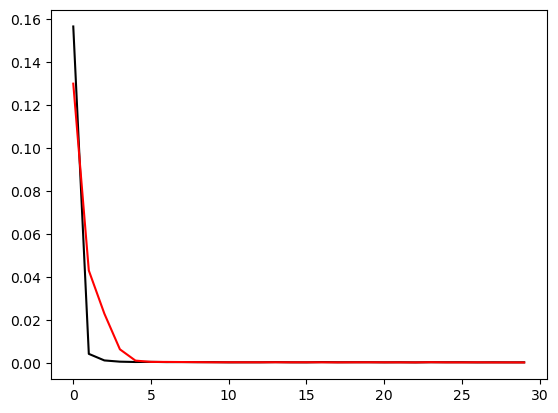

In [16]:
plt.plot(train_loss, c='k')
plt.plot(valid_loss, c='r')
plt.show()

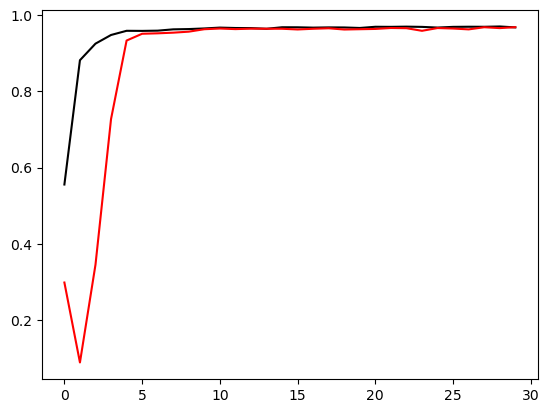

In [17]:
plt.plot(train_corr, c='k')
plt.plot(valid_corr, c='r')
plt.show()

In [18]:
for i in tests_loader:
    print(i['input'].squeeze(dim=2).shape)
    print(i['label'].squeeze(dim=2).shape)
    break

torch.Size([64, 4, 33, 33])
torch.Size([64, 1, 33, 33])


In [19]:
d_inp = i['input'].squeeze(dim=2).cpu().detach().numpy()[:,nc-1,:,:].flatten()
e_out = net(i['input'].squeeze(dim=2).to(device, dtype=torch.float)).cpu().detach().numpy()[:,0,:,:].flatten()
f_lab = i['label'].squeeze(dim=2).cpu().detach().numpy()[:,0,:,:].flatten()

In [20]:
(np.corrcoef(e_out, f_lab)) # unet and era5

array([[1.       , 0.9741621],
       [0.9741621, 1.       ]])

In [22]:
np.corrcoef(d_inp, f_lab) # cesm and era5

array([[1.        , 0.96740835],
       [0.96740835, 1.        ]])

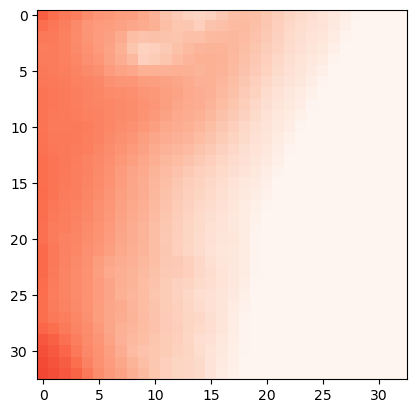

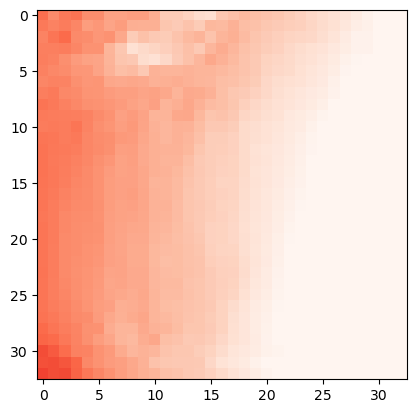

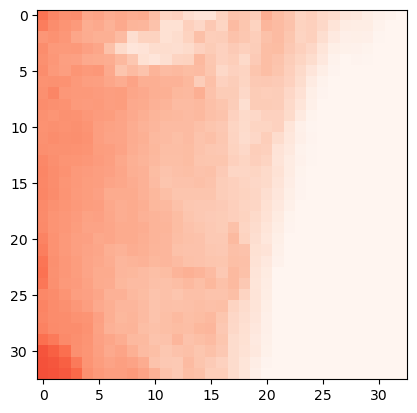

In [23]:
sample_ = 1

a_inp = i['input'].squeeze(dim=2).cpu().detach().numpy()[:,nc-1,:,:][sample_]
b_out = net(i['input'].squeeze(dim=2).to(device, dtype=torch.float)).cpu().detach().numpy()[:,0,:,:][sample_]
c_lab = i['label'].squeeze(dim=2).cpu().detach().numpy()[:,0,:,:][sample_]

plt.imshow(a_inp, vmin=0.5, vmax=1., cmap='Reds'); plt.show()
plt.imshow(b_out, vmin=0.5, vmax=1., cmap='Reds'); plt.show()
plt.imshow(c_lab, vmin=0.5, vmax=1., cmap='Reds'); plt.show()

In [24]:
d_inp = i['input'].squeeze(dim=2).cpu().detach().numpy()[:,nc-1,:,:]
e_out = net(i['input'].squeeze(dim=2).to(device, dtype=torch.float)).cpu().detach().numpy()[:,0,:,:]
f_lab = i['label'].squeeze(dim=2).cpu().detach().numpy()[:,0,:,:]

In [25]:
inp = xr.DataArray(   # cesm input into unet
       d_inp.squeeze(),
       dims=["time", "lat", "lon"],
       name='var'
   ).sortby('lon')

fct = xr.DataArray(    # unet output
       e_out.squeeze(),
       dims=["time", "lat", "lon"],
       name='var'
   ).sortby('lon')

obs = xr.DataArray(    # era5
       f_lab.squeeze(),
       dims=["time", "lat", "lon"],
       name='var'
   ).sortby('lon')

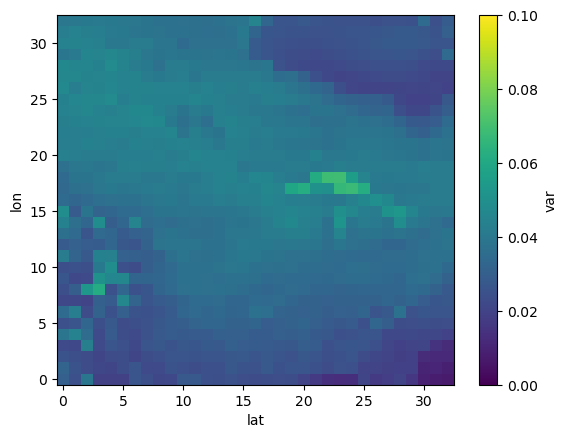

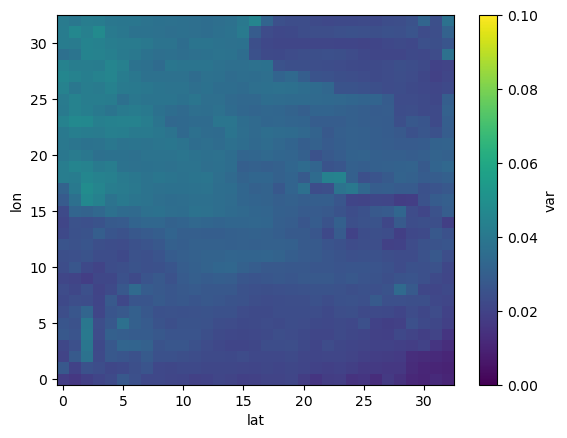

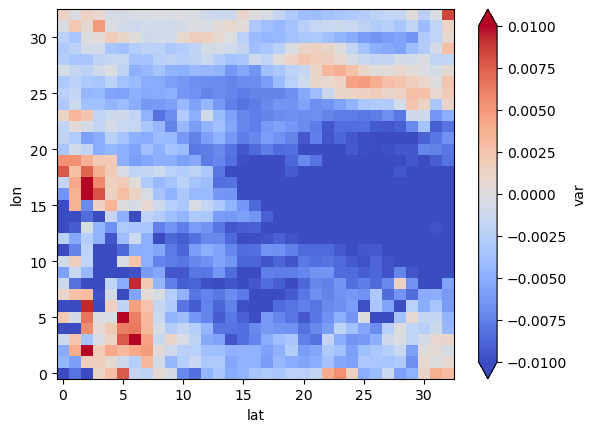

In [26]:
rmse1 = xs.rmse(inp, obs, dim='time')
rmse1.plot.pcolormesh('lat', 'lon', vmin=0, vmax=0.1); plt.show() # cesm and era5

rmse2 = xs.rmse(fct, obs, dim='time')
rmse2.plot.pcolormesh('lat', 'lon', vmin=0, vmax=0.1); plt.show() # unet and era5

(rmse2-rmse1).plot.pcolormesh('lat', 'lon', vmin=-0.01, vmax=0.01, cmap='coolwarm'); plt.show()  # unet - cesm

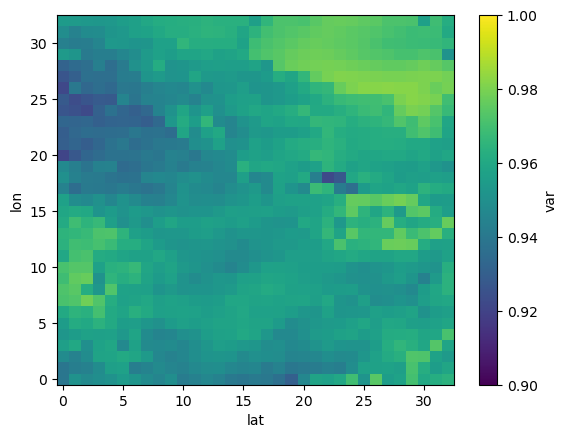

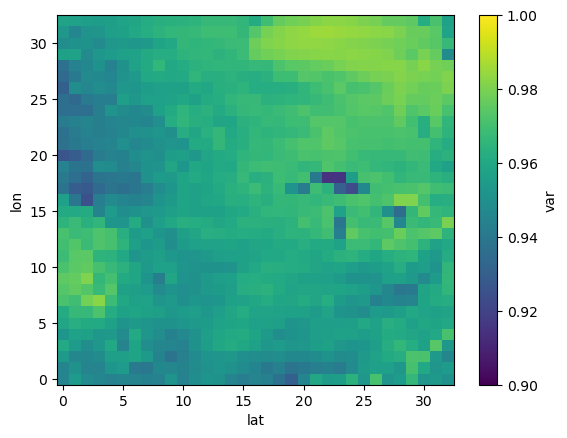

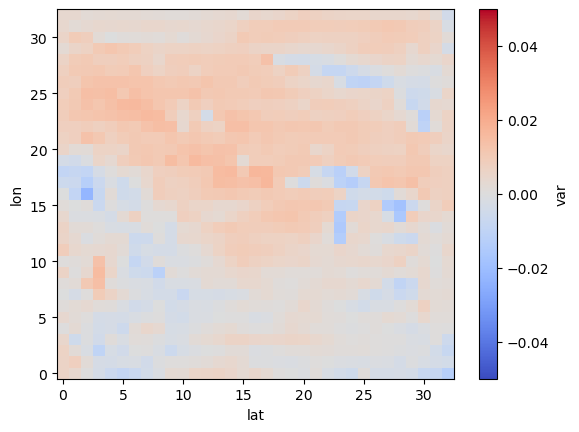

In [27]:
acc1 = xs.pearson_r(inp, obs, dim='time') 
acc1.plot.pcolormesh('lat', 'lon', vmin=0.9, vmax=1.0); plt.show() # cesm and era5

acc2 = xs.pearson_r(fct, obs, dim='time') 
acc2.plot.pcolormesh('lat', 'lon', vmin=0.9, vmax=1.0); plt.show() # unet and era5

(acc2-acc1).plot.pcolormesh('lat', 'lon', vmin=-0.05, vmax=0.05, cmap='coolwarm'); plt.show()  # unet - cesm

a_inp = reverse_negone(
    i['input'].squeeze(dim=2).cpu().detach().numpy()[:,nc-1,:,:], 
    train.min_val, 
    train.max_val)[sample_]

b_out = reverse_negone(
    net(i['input'].squeeze(dim=2).to(
        device, dtype=torch.float)).cpu().detach().numpy()[:,0,:,:], 
    train.min_val, 
    train.max_val)[sample_]

c_lab = reverse_negone(
    i['label'].squeeze(dim=2).cpu().detach().numpy()[:,0,:,:], 
    train.min_val, 
    train.max_val)[sample_]

plt.imshow(a_inp, vmin=-1, vmax=1, cmap='seismic'); plt.show()
plt.imshow(b_out, vmin=-1, vmax=1, cmap='seismic'); plt.show()
plt.imshow(c_lab, vmin=-1, vmax=1, cmap='seismic'); plt.show()